# Attention Visualization on Face Recognition Datasets

In this notebook, we will visualize attention map obtained from TDMPNet with VGG and LResNet50E-IR backbone. We will use the following datasets for visualization: 
1. CASIA-Webface
2. Labeled Face in the Wild (LFW) dataset
3. Masked-LFW dataset

## Content

* [1. CASIA-Webface Dataset](#1)
* &nbsp;&nbsp;&nbsp;&nbsp; [1.1. Identity Prediction per Sample Image](#1.1)
* &nbsp;&nbsp;&nbsp;&nbsp; [1.2. Good Predictions](#1.2)
* &nbsp;&nbsp;&nbsp;&nbsp; [1.3. Bad Predictions](#1.3)
* [2. Masked-LFW Dataset](#2)
* &nbsp;&nbsp;&nbsp;&nbsp; [2.1. Pairs With & Without Mask](#2.1)
* &nbsp;&nbsp;&nbsp;&nbsp; [2.2. Filtering Out Mask Features](#2.2)
* &nbsp;&nbsp;&nbsp;&nbsp; [2.3. Good Predictions](#2.3)
* &nbsp;&nbsp;&nbsp;&nbsp; [2.4. Bad Predictions](#2.4)

In [1]:
# run this cell only ONCE!
import os
os.chdir("..")
from collections import defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torchvision import transforms

from eval_net import extract_feature, extract_mask_features
from config.config_parser import get_default_cfg, merge_cfg_from_file, \
    get_dataloader_from_cfg, get_model_from_cfg

In [20]:
experiment = 0 # change to 0, 1, 2

In [21]:
if experiment == 0:
    config_file = "pretrained_weight/LResNet50IR_Attn_100000_64_second_CASIA/config.yaml"
    weight = "pretrained_weight/LResNet50IR_Attn_100000_64_second_CASIA/last.pt"
    mcp_weight = "pretrained_weight/LResNet50IR_Attn_100000_64_second_CASIA/mcp_last.pt"
    save_dir = "visualization/LResNet50IR_Attn_100000_64_second_CASIA/" # change to custom folder name

elif experiment == 1:
    config_file = "pretrained_weight/VGG_Attn_50000_128_last_CASIA/config.yaml"
    weight = "pretrained_weight/VGG_Attn_50000_128_last_CASIA/last.pt"
    mcp_weight = "pretrained_weight/VGG_Attn_50000_128_last_CASIA/mcp_last.pt"
    save_dir = "visualization/VGG_Attn_50000_128_last_CASIA/" # change to custom folder name

elif experiment == 2:
    config_file = "pretrained_weight/VGG_Attn_100000_64_second_CASIA/config.yaml"
    weight = "pretrained_weight/VGG_Attn_100000_64_second_CASIA/last.pt"
    mcp_weight = "pretrained_weight/VGG_Attn_100000_64_second_CASIA/mcp_last.pt"
    save_dir = "visualization/VGG_Attn_100000_64_second_CASIA/" # change to custom folder name


thresh_u = 0.1
thresh_l = 0.8
device = "cuda" if torch.cuda.is_available() else "cpu"

<a name='1'> </a>
## 1. CASIA-Webface Dataset

In this section, we will analyse the results on CASIA-Webface dataset. This includes: 
1. Identity prediction for one sample
2. Good predictions (correctly predicted examples)
3. Bad predictions (misclassified examples)

In [22]:
dataset_name = "casia"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [dataset_name] 
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [""] # No need test set
cfg["SOLVER"]["BATCH_SIZE"] = 1
cfg["MODEL"]["ATTN"]["PERCENT_U"] = thresh_u
cfg["MODEL"]["ATTN"]["PERCENT_L"] = thresh_l

# get model and dataloader
model, classifier, _ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))
classifier.load_state_dict(torch.load(mcp_weight))

# freeze parameters
for p in model.parameters():
    p.requires_grad = False
    
for p in classifier.parameters():
    p.requires_grad = False
    
num_images, data_loaders, *_ = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

In [23]:
def predict(model, classifier, image, label, device = 'cpu'):
    model.to(device)
    model.eval()
    
    classifier.to(device)
    classifier.eval()
    
    image, label = image.to(device), label.to(device)
    
    with torch.no_grad():
        feature, additional_loss, additional_output = model(image)
        score = classifier(feature["features"], label)
        
        score_prob = F.softmax(score, dim = 1)
        pred = torch.max(score_prob, dim = 1).indices.to("cpu")
        
        attn_second_last = additional_output['attn_map'][-1]
    
    return pred, attn_second_last

<a name='1.1'> </a>
### 1.1. Identity Prediction per Sample Image

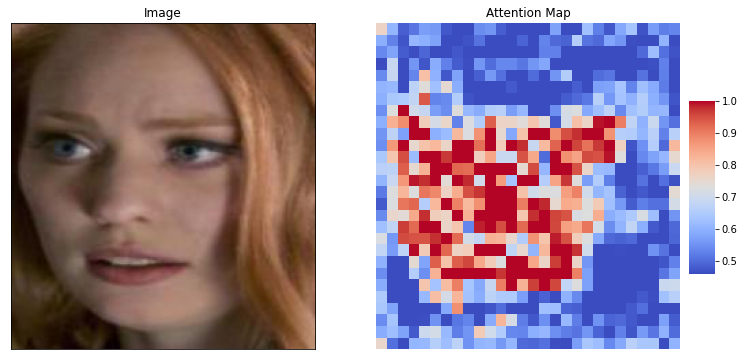

Ground truth: 8597
Prediction: 8597


In [24]:
to_PIL = transforms.Compose([
    transforms.Normalize(mean = (0, 0, 0), std = (1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean = (-0.5, -0.5, -0.5), std = (1, 1, 1)),
    transforms.ToPILImage()
])

data, label = next(data_loader_iter)
img = to_PIL(torch.squeeze(data.detach().clone()))

# make predictions
pred, attn_second_last= predict(model, classifier, data, label, device = device)
attn_second_last = torch.squeeze(attn_second_last).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(1,2, figsize = (12,6))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax[0].imshow(img, aspect = "auto")
ax[0].set_title("Image")

sns.heatmap(attn_second_last, cmap = "coolwarm", ax = ax[1], cbar = True, cbar_ax = cbar_ax)
ax[1].set_title("Attention Map")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "one_sample_prediction_CASIA.jpg"))

print(f"Ground truth: {label.item()}")
print(f"Prediction: {pred.item()}")

From above visualization, we can observe that the model tends to predict eyes, nose, and mouth part of the face as denoted by reddish color on Attention map. Next we will see some visualizations of Attention map on high prediction scores (good predictions) and low prediction scores (bad predictions)

<a name='1.2'> </a>
### 1.2. Good Predictions

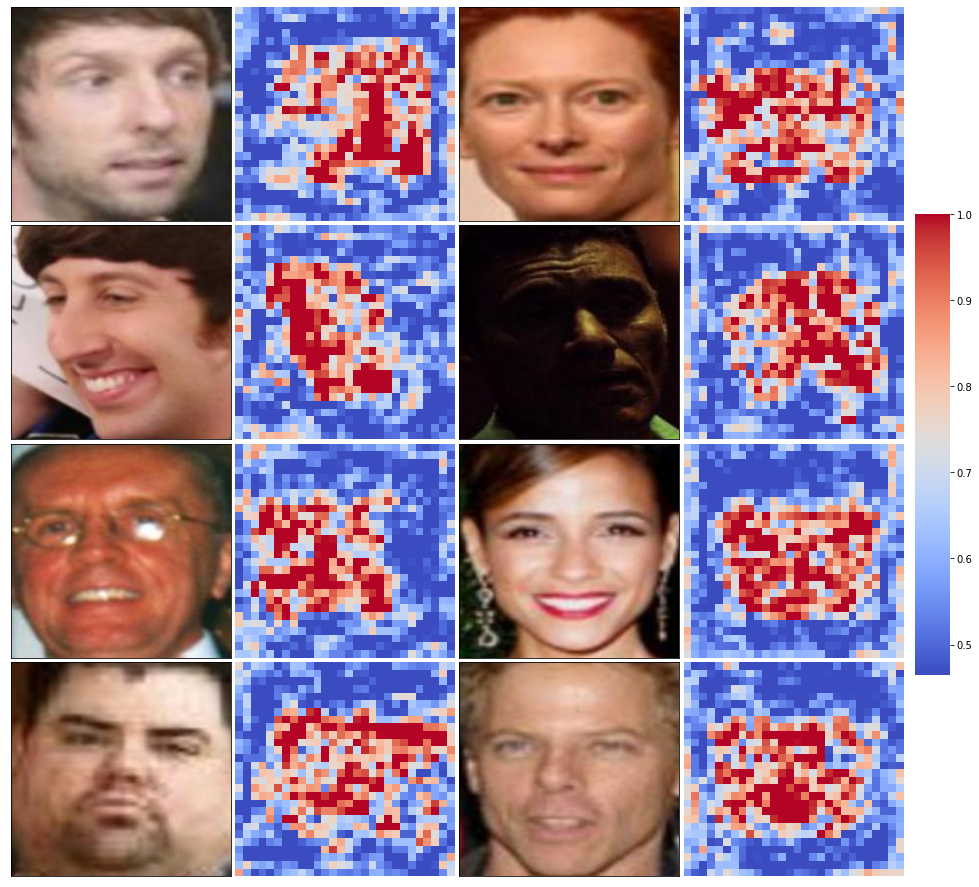

In [25]:
data_loader_iter = iter(data_loaders[0])
to_PIL = transforms.Compose([
    transforms.Normalize(mean = (0, 0, 0), std = (1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean = (-0.5, -0.5, -0.5), std = (1, 1, 1)),
    transforms.ToPILImage()
])

num_images = 8
good_images = []

while len(good_images) < num_images:
    data, label = next(data_loader_iter)
    img = to_PIL(torch.squeeze(data.detach().clone()))
    
    pred, attn_second_last = predict(model, classifier, data, label, device = device)
    attn_second_last = torch.squeeze(attn_second_last).to("cpu").numpy()
    
    if pred.item() == label.item():
        good_images.append([img, attn_second_last])

# visualize 4×4 grid
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, len(ax), 2):
    ax[i].imshow(good_images[i//2][0], aspect = "auto")
    sns.heatmap(good_images[i//2][1], cmap = 'coolwarm', 
                ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

fig.savefig(os.path.join(save_dir, "good_predictions_CASIA.jpg"))

<a name='1.3'> </a>
### 1.3. Bad Predictions

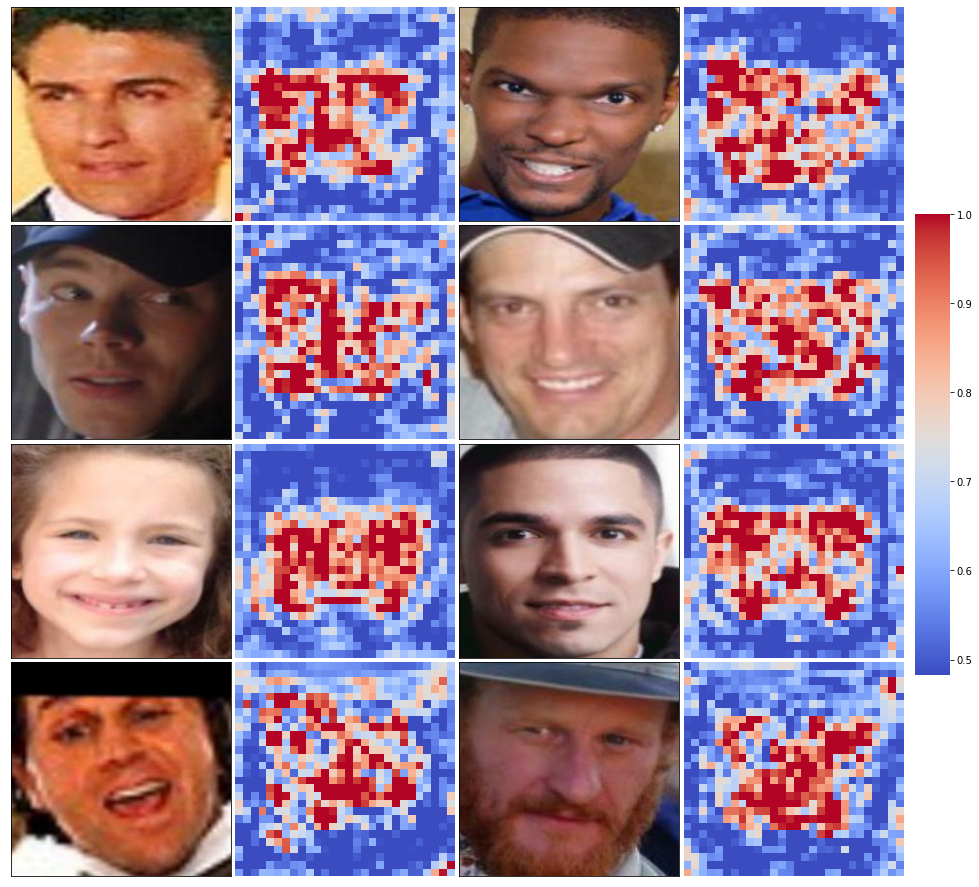

In [26]:
data_loader_iter = iter(data_loaders[0])
to_PIL = transforms.Compose([
    transforms.Normalize(mean = (0, 0, 0), std = (1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean = (-0.5, -0.5, -0.5), std = (1, 1, 1)),
    transforms.ToPILImage()
])

num_images = 8
bad_images = []

while len(bad_images) < num_images:
    data, label = next(data_loader_iter)
    img = to_PIL(torch.squeeze(data.detach().clone()))
    
    pred, attn_second_last = predict(model, classifier, data, label, device = device)
    attn_second_last = torch.squeeze(attn_second_last).to("cpu").numpy()
    
    if pred.item() != label.item():
        bad_images.append([img, attn_second_last])

# visualize 4×4 grid
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, len(ax), 2):
    ax[i].imshow(bad_images[i//2][0], aspect = "auto")
    sns.heatmap(bad_images[i//2][1], cmap = 'coolwarm', 
                ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()
fig.savefig(os.path.join(save_dir, "bad_predictions_CASIA.jpg"))

<a name='2'> </a>
## 2. Masked LFW Dataset

In this section we will analyse the attention map on original and masked image pairs from Masked-LFW dataset. Specifically, we will see whether the attention map on original images are completely different to the masked versions. 

In [27]:
from config.config_parser import get_parameters_from_cfg

dataset_name = "lfw_masked"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] # No need train set
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name] 
cfg["SOLVER"]["BATCH_SIZE"] = 1
cfg["MODEL"]["ATTN"]["PERCENT_U"] = thresh_u
cfg["MODEL"]["ATTN"]["PERCENT_L"] = thresh_l
_, test_root, test_images, test_annot = get_parameters_from_cfg(cfg)["TEST"][0]

# get model and dataloader
model, *_ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))

# freeze parameters
for p in model.parameters():
    p.requires_grad = False

In [28]:
def read_pairs(root, filelist):
    with open(os.path.join(root, filelist), 'r') as f:
        pairs_lines = f.readlines()[:]
    
    return pairs_lines


def get_pairs_images(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
  
    if len(pair_line) == 3:
        if os.path.splitext(pair_line[0])[1] in ['.jpg', '.png'] and os.path.splitext(pair_line[1])[1] in ['.jpg', '.png']:
            filename1 = pair_line[0]
            filename2 = pair_line[1]
        else:
            # same identity
            fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
            fileid2 = '0' * (4 - len(str(pair_line[2])) ) + str(pair_line[2])
            filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
            filename2 = f'{pair_line[0]}_' + fileid2 + file_ext + '.jpg'
    elif len(pairs) == 4:
        # different identity
        fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
        fileid2 = '0' * (4 - len(str(pair_line[3])) ) + str(pair_line[3])
        filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
        filename2 = f'{pair_line[2]}_' + fileid2 + file_ext + '.jpg'
        
    return filename1, filename2, False


def get_masked_pairs(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
    mask_exist = False
    
    masked_file = ori_file = pair_line[1]
    if masked_file.split('_')[-1] in ['cloth.jpg', 'KN95.jpg', 'N95.jpg']:
        ori_file = '_'.join(masked_file.split('_')[:-1]) + '.jpg'
        mask_exist = True
        
    return ori_file, masked_file, mask_exist


def predict(model, image, device = 'cpu'):
    model.to(device)
    model.eval()
    
    image = image.to(device)
    
    with torch.no_grad():
        feature, additional_loss, additional_output = model(image)
        
        attn_second_last = additional_output["attn_map"][-1]
        sim_cluster = additional_output["sim_cluster"][-1]
    
    return feature, attn_second_last, sim_cluster
        
        
# define transformation
transform_face = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

pairs = read_pairs(test_root, test_annot)

<a name='2.1'> </a>
### 2.1. Pairs With & Without Mask

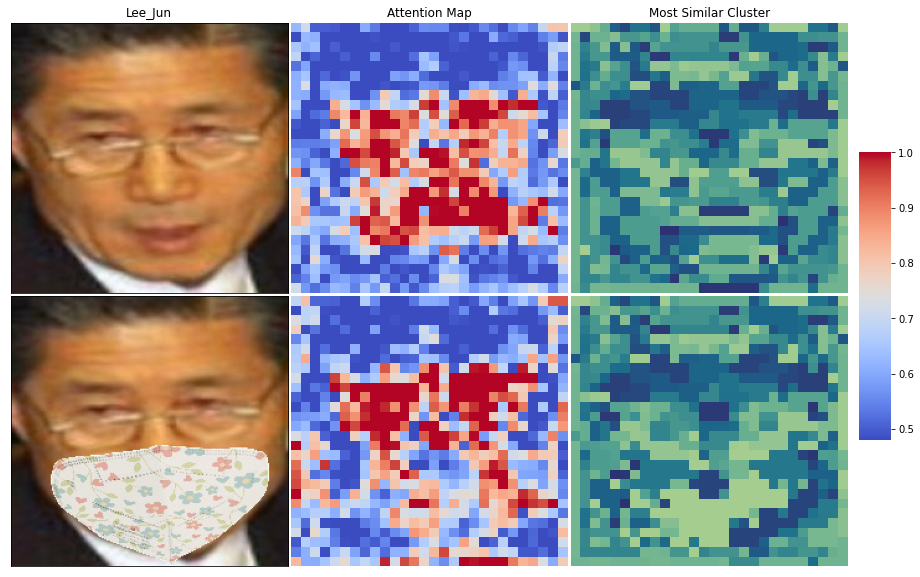

In [29]:
sample_idx = np.random.randint(len(pairs), size = 1)[0]

sample_pairs = pairs[sample_idx]
filename1, filename2, _ = get_masked_pairs(sample_pairs)

img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

tensor_img1 = transform_face(img1).unsqueeze(0)
tensor_img2 = transform_face(img2).unsqueeze(0)

_, attn_second_last, sim_cluster = predict(model, tensor_img1, device = device)
attn_second_last = torch.squeeze(attn_second_last).to("cpu").numpy()
sim_cluster = torch.squeeze(sim_cluster).to("cpu").numpy()

_, attn_second_last2, sim_cluster2 = predict(model, tensor_img2, device = device)
attn_second_last2 = torch.squeeze(attn_second_last2).to("cpu").numpy()
sim_cluster2 = torch.squeeze(sim_cluster2).to("cpu").numpy()

data = [[img1, attn_second_last, sim_cluster], 
        [img2, attn_second_last2, sim_cluster2]]

# visualize the result
id_name1 = filename1.split('_0')[0]
id_name2 = filename2.split('_0')[0]

fig, ax = plt.subplots(2,3, figsize = (15,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

for i in range(0, len(ax), 3):
    ax[i].imshow(data[i//3][0], aspect = "auto")
    sns.heatmap(data[i//3][1], cmap = 'coolwarm', 
                ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)
    sns.heatmap(data[i//3][2], cmap = "crest", ax = ax[i+2], cbar = False, annot = False)

ax[0].set_title(id_name1)
ax[1].set_title("Attention Map")
ax[2].set_title("Most Similar Cluster")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.show()
fig.savefig(os.path.join(save_dir, "single_pair_Masked-LFW.jpg"))

From above figure, we observed that the attention map is different, especially on the mouth and nose part. In addition, we noticed that the facial masks are contaminating their nearby features and resulting in slight change around the eyes part. Therefore, we came up with another protocol to extract the un-occluded facial parts and compute similarity with them. 

<a name='2.2'> </a>
### 2.2. Filtering Out Mask Features

In [30]:
mask_extractor_config = "pretrained_weight/LResNet50IR_Attn_100000_64_second_CASIA/config.yaml"
mask_extractor_weight = "pretrained_weight/LResNet50IR_Attn_100000_64_second_CASIA/last.pt"

extractor_cfg = get_default_cfg()
extractor_cfg = merge_cfg_from_file(extractor_cfg, mask_extractor_config)
mask_extractor, *_ = get_model_from_cfg(extractor_cfg)
mask_extractor.load_state_dict(torch.load(mask_extractor_weight))

for p in mask_extractor.parameters():
    p.requires_grad = False
    
mask_extractor.to(device = device)
mask_extractor = mask_extractor.eval()

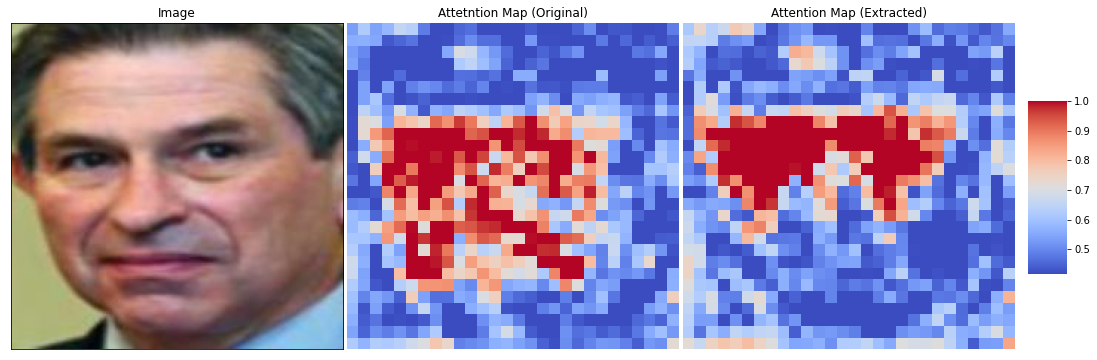

Identity: match
Similarity normal protocol: 0.5660256743431091
Similarity filter mask protocol: 0.571151077747345


In [31]:
sample_idx = np.random.randint(len(pairs), size = 1)[0]

sample_pairs = pairs[sample_idx]
filename1, filename2, _ = get_masked_pairs(sample_pairs)

img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

tensor_img1 = transform_face(img1).unsqueeze(0)
tensor_img2 = transform_face(img2).unsqueeze(0)

no_mask_features, mask_features, interm_output = extract_mask_features(model, mask_extractor, img1, img2, 
                                                                       device, attention_maps = True)

data = [img1, 
        interm_output["ori"][0].detach().to("cpu").numpy(), 
        interm_output["mask"][0].detach().to("cpu").numpy()]

# visualize the result
id_name1 = filename1.split('_0')[0]
id_name2 = filename2.split('_0')[0]

fig, ax = plt.subplots(1, 3, figsize = (18,6))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

ax[0].imshow(data[0], aspect = "auto")
sns.heatmap(data[1], cmap = 'coolwarm', ax = ax[1], cbar = True, cbar_ax = cbar_ax)
sns.heatmap(data[2], cmap = 'coolwarm', ax = ax[2], cbar = False, cbar_ax = None)

ax[0].set_title("Image")
ax[1].set_title("Attetntion Map (Original)")
ax[2].set_title("Attention Map (Extracted)")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.show()

# show similarity
feat1 = extract_feature(img1, model, device = device)
feat2 = extract_feature(img2, model, device = device)

dist = feat1.dot(feat2) / (feat1.norm() * feat2.norm() + 1e-5)
dist_mask = no_mask_features.dot(mask_features) / (no_mask_features.norm() * mask_features.norm() + 1e-5)

print("Identity:", "match" if id_name1 == id_name2 else "different")
print("Similarity normal protocol:", dist.item())
print("Similarity filter mask protocol:", dist_mask.item())

fig.savefig(os.path.join(save_dir, "filtering_mask_Masked-LFW.jpg"))

From above figure, we successfully filter out the mouth and nose part of images and we can also see that applying filter-mask protocol could increase the confidence of the system. We used this protocol for evaluation with Masked-LFW dataset. Next, we will visualize good and bad predictions.

<a name='2.3'> </a>
### 2.3. Good Predictions

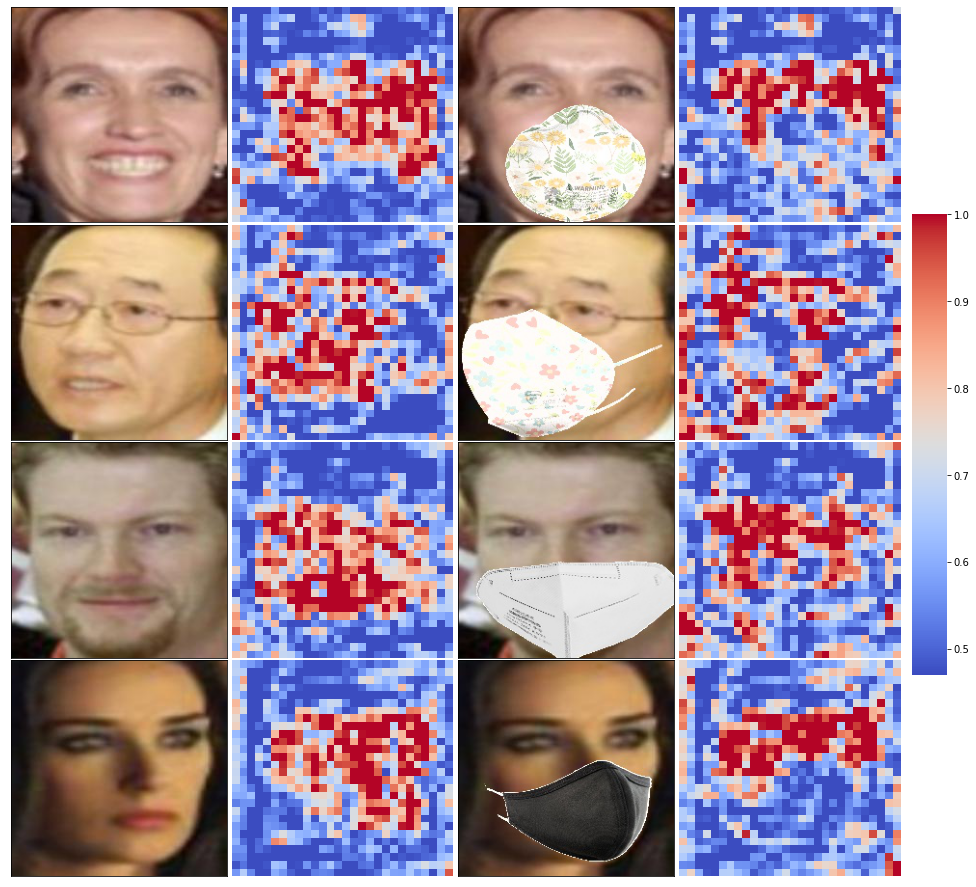

In [32]:
good_thresh = 0.7

num_cases = 4
good_preds = []
identity_record = defaultdict(lambda: False) # dictionary to handle duplicate images

for idx in range(len(pairs)):
    one_pairs = pairs[idx]
    filename1, filename2, mask_exist = get_masked_pairs(one_pairs)

    # only get the mask and unmasked pairs
    if not mask_exist:
        continue

    img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
    img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

    tensor_img1 = transform_face(img1).unsqueeze(0)
    tensor_img2 = transform_face(img2).unsqueeze(0)

    with torch.no_grad():
        feature, attn_second_last, _ = predict(model, tensor_img1, device = device)
        feat = feature["features"][0]
        attn = torch.squeeze(attn_second_last).to("cpu").numpy()
        
        feature2, attn_second_last2, _ = predict(model, tensor_img2, device = device)
        feat2 = feature2["features"][0]
        attn2 = torch.squeeze(attn_second_last2).to("cpu").numpy()

        dist = feat.dot(feat2) / (feat.norm() * feat2.norm() + 1e-5)
    
    if dist >= good_thresh and not identity_record[filename1]:
        good_preds.append([img1, attn, img2, attn2])
        identity_record[filename1] = True
    
    if len(good_preds) == num_cases:
        break


# visualize 4×4 grid
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 4):
    ax[i].imshow(good_preds[i//4][0])
    ax[i+2].imshow(good_preds[i//4][2])
    
    sns.heatmap(good_preds[i//4][1], cmap = 'coolwarm', ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)
    sns.heatmap(good_preds[i//4][3], cmap = 'coolwarm', ax = ax[i+3], cbar = False, cbar_ax = None)

for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.show()

# save the image
fig.savefig(os.path.join(save_dir, "good_predictions_Masked-LFW.jpg"))

<a name='2.4'> </a>
### 2.4. Bad Predictions

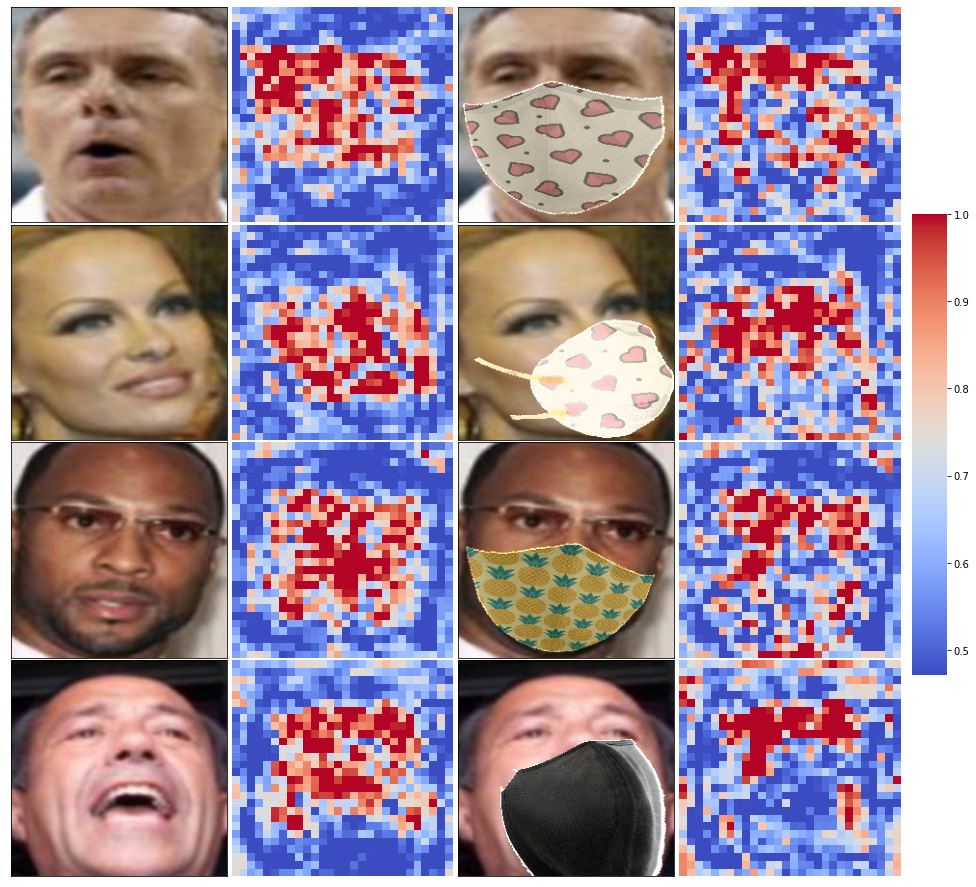

In [33]:
bad_thresh = 0.3

num_cases = 4
bad_preds = []
identity_record = defaultdict(lambda: False)

for idx in range(len(pairs)):
    one_pairs = pairs[idx]
    filename1, filename2, mask_exist = get_masked_pairs(one_pairs)

    # only get the mask and unmasked pairs
    if not mask_exist:
        continue

    img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
    img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

    tensor_img1 = transform_face(img1).unsqueeze(0)
    tensor_img2 = transform_face(img2).unsqueeze(0)

    with torch.no_grad():
        feature, attn_second_last, _ = predict(model, tensor_img1, device = device)
        feat = feature["features"][0]
        attn = torch.squeeze(attn_second_last).to("cpu").numpy()
        
        feature2, attn_second_last2, _ = predict(model, tensor_img2, device = device)
        feat2 = feature2["features"][0]
        attn2 = torch.squeeze(attn_second_last2).to("cpu").numpy()

        dist = feat.dot(feat2) / (feat.norm() * feat2.norm() + 1e-5)
    
    if dist <= bad_thresh and not identity_record[filename1]:
        bad_preds.append([img1, attn, img2, attn2])
        identity_record[filename1] = True
    
    if len(bad_preds) == num_cases:
        break


# visualize 4×4 grid
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 4):
    ax[i].imshow(bad_preds[i//4][0])
    ax[i+2].imshow(bad_preds[i//4][2])
    
    sns.heatmap(bad_preds[i//4][1], cmap = 'coolwarm', ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)
    sns.heatmap(bad_preds[i//4][3], cmap = 'coolwarm', ax = ax[i+3], cbar = False, cbar_ax = None)

for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.show()

fig.savefig(os.path.join(save_dir, "bad_predictions_Masked-LFW.jpg"))

From above figures, we can see that facial masks could be filtered out successfully for images with good predictions. As for the bad predictions, we can observe some important keypoints:
1. The faces are not properly aligned which suggest that more sophisticated face alignment algorithms are needed.
2. The mask might not be filtered out perfectly. This can be seen from reddish artifact around nose and mouth area.